In [1]:
import os
import sys
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
sys.path.append("../../Utils")
from loaders import HNSCCFeatureHandler

METADATA_PATH = "../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW.csv"
VALID_IDS_PATH = "../../Utils/Lists/cv_ids.txt"
HOLD_IDS_PATH = '../../Utils/Lists/holdout_ids.txt'

hc_data = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH, HOLD_IDS_PATH)
_ = hc_data.load_feature_to_dataframe("../../Data/*.hg38.frag.interval_mds.tsv", 0, 4)
z = hc_data.normalize_zscore()
_ = hc_data.merge_feature_metadata()
z = hc_data.batch_correct()

with open('treatment_response_dict.pkl', 'rb') as f:
    truth = pickle.load(f)

with open('predicted_treatment_response_dict.pkl', 'rb') as f:
    predicted = pickle.load(f)

def pval_heatmap_response(df, name):
    import numpy as np
    import seaborn as sns
    import marsilea as ma
    from marsilea.plotter import TextMesh, Colors, MarkerMesh

    mask = np.tril(np.ones(df.shape), k=0).astype(bool)
    data_df = df.mask(mask)
    data = data_df.to_numpy()
    cols = data_df.columns
    rows = data_df.index

    def get_responder(info):
        return ['Non-Responder' if x.startswith('N') else 'Responder' for x in info]
    def get_stratification(info):
        return ['Intermediate' if x.endswith('e') else 'High' for x in info]

    colors = sns.color_palette("colorblind", 6)
    c0, c2, c3, c5 = colors[0], colors[2], colors[3], colors[5]
    resp_palette = {'Responder': c0, 'Non-Responder': c5}
    strat_palette = {'High': c3, 'Intermediate': c2}

    col_resp  = Colors(get_responder(cols),      label="Treatment Response", palette=resp_palette, label_loc='left')
    col_strat = Colors(get_stratification(cols), label="Stratification",      palette=strat_palette, label_loc='left')
    row_resp  = Colors(get_responder(rows),      label="Treatment Response", palette=resp_palette)
    row_strat = Colors(get_stratification(rows), label="Stratification",      palette=strat_palette)

    min_p = np.nanmin(data[data > 0])
    log_norm = LogNorm(vmin=0.001, vmax=1)

    h = ma.Heatmap(
        data,
        linewidth=1,
        label="p-value",
        cmap="PuRd_r",
        norm=log_norm,
        width=2, height=2
    )
    mesh = MarkerMesh(np.eye(4), color="black", marker="x", size=50)
    h.add_layer(TextMesh(data, color="white", rotation=-45), name="text")
    h.add_layer(mesh, name="text")
    h.add_right(row_strat, size=0.2, pad=0.05)
    h.add_right(row_resp,  size=0.2, pad=0.00)
    h.add_top(col_strat,   size=0.2, pad=0.05)
    h.add_top(col_resp,    size=0.2, pad=0.00)

    h.add_legends(stack_size=4)
    h.render()
    plt.savefig(f"{name}.pdf", bbox_inches="tight")

def pval_heatmap_tumor(df, name):
    import numpy as np
    import seaborn as sns
    import marsilea as ma
    from marsilea.plotter import TextMesh, Colors, MarkerMesh

    mask = np.tril(np.ones(df.shape), k=0).astype(bool)
    data_df = df.mask(mask)
    data = data_df.to_numpy()
    cols = data_df.columns
    rows = data_df.index

    def get_responder(info):
        return ['High' if x.startswith('N') else 'Low' for x in info]
    def get_stratification(info):
        return ['Intermediate' if x.endswith('e') else 'High' for x in info]

    colors = sns.color_palette("colorblind", 6)
    c0, c2, c3, c5 = colors[0], colors[2], colors[3], colors[5]
    resp_palette = {'Low': c0, 'High': c5}
    strat_palette = {'High': c3, 'Intermediate': c2}

    col_resp  = Colors(get_responder(cols),      label="Tumor Fraction", palette=resp_palette, label_loc='left')
    col_strat = Colors(get_stratification(cols), label="Stratification",      palette=strat_palette, label_loc='left')
    row_resp  = Colors(get_responder(rows),      label="Tumor Fraction", palette=resp_palette)
    row_strat = Colors(get_stratification(rows), label="Stratification",      palette=strat_palette)

    min_p = np.nanmin(data[data > 0])
    log_norm = LogNorm(vmin=0.001, vmax=1)

    h = ma.Heatmap(
        data,
        linewidth=1,
        label="p-value",
        cmap="PuRd_r",
        norm=log_norm,
        width=2, height=2
    )
    mesh = MarkerMesh(np.eye(4), color="black", marker="x", size=50)
    h.add_layer(TextMesh(data, color="white", rotation=-45), name="text")
    h.add_layer(mesh, name="text")
    h.add_right(row_strat, size=0.2, pad=0.05)
    h.add_right(row_resp,  size=0.2, pad=0.00)
    h.add_top(col_strat,   size=0.2, pad=0.05)
    h.add_top(col_resp,    size=0.2, pad=0.00)

    h.add_legends(stack_size=4)
    h.render()
    plt.savefig(f"{name}.pdf", bbox_inches="tight")

def pval_heatmap_ihc(df, name):
    import numpy as np
    import seaborn as sns
    import marsilea as ma
    from marsilea.plotter import TextMesh, Colors, MarkerMesh

    mask = np.tril(np.ones(df.shape), k=0).astype(bool)
    data_df = df.mask(mask)
    data = data_df.to_numpy()
    cols = data_df.columns
    rows = data_df.index

    def get_responder(info):
        return ['0' if x.startswith('0') else '1-19' if x.startswith('1') else '>20' for x in info]

    def get_stratification(info):
        return ['Intermediate' if x.endswith('e') else 'High' for x in info]

    colors = sns.color_palette("colorblind", 10)
    c7, c2, c3, c1, c4 = colors[7], colors[2], colors[3], colors[1], colors[4]
    resp_palette = {'0': c7, '1-19': c1, '>20': c4}
    strat_palette = {'High': c3, 'Intermediate': c2}

    col_resp  = Colors(get_responder(cols),      label="PD-L1 IHC", palette=resp_palette, label_loc='left')
    col_strat = Colors(get_stratification(cols), label="Stratification",      palette=strat_palette, label_loc='left')
    row_resp  = Colors(get_responder(rows),      label="PD-L1 IHC", palette=resp_palette)
    row_strat = Colors(get_stratification(rows), label="Stratification",      palette=strat_palette)

    min_p = np.nanmin(data[data > 0])
    log_norm = LogNorm(vmin=0.001, vmax=1)

    h = ma.Heatmap(
        data,
        linewidth=1,
        label="p-value",
        cmap="PuRd_r",
        norm=log_norm,
        width=2.75, height=2.75
    )
    mesh = MarkerMesh(np.eye(6), color="black", marker="x", size=50)
    h.add_layer(TextMesh(data, color="white", rotation=-45), name="text")
    h.add_layer(mesh, name="text")
    h.add_right(row_strat, size=0.2, pad=0.05)
    h.add_right(row_resp,  size=0.2, pad=0.00)
    h.add_top(col_strat,   size=0.2, pad=0.05)
    h.add_top(col_resp,    size=0.2, pad=0.00)

    h.add_legends(stack_size=4)
    h.render()
    plt.savefig(f"{name}.pdf", bbox_inches="tight")

In [2]:
s = hc_data.get_metadata_col('Patient Number', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
switched_df = s.reset_index().drop_duplicates(subset='Patient Number', keep='first')
switched = switched_df.set_index('Patient Number')['index']

In [3]:
predicted = {switched.get(k, k): v for k, v in predicted.items()}
truth = {switched.get(k, k): v for k, v in truth.items()}

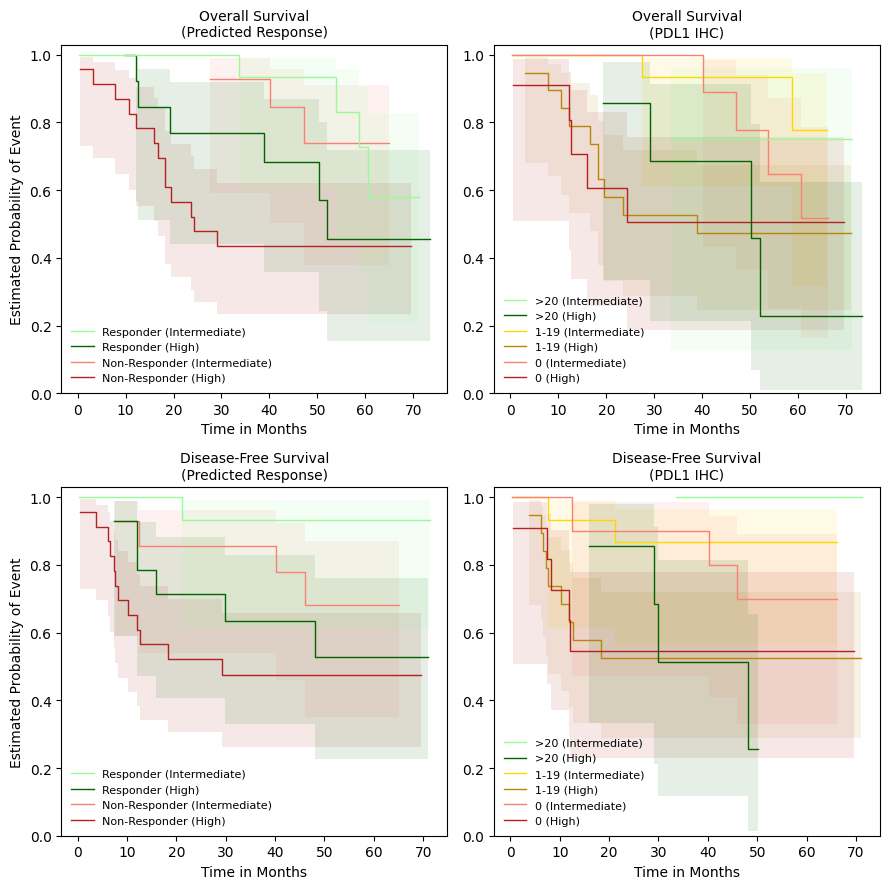

In [4]:
pairwise_prediction = hc_data.survival_curve(predicted, name='Predicted')

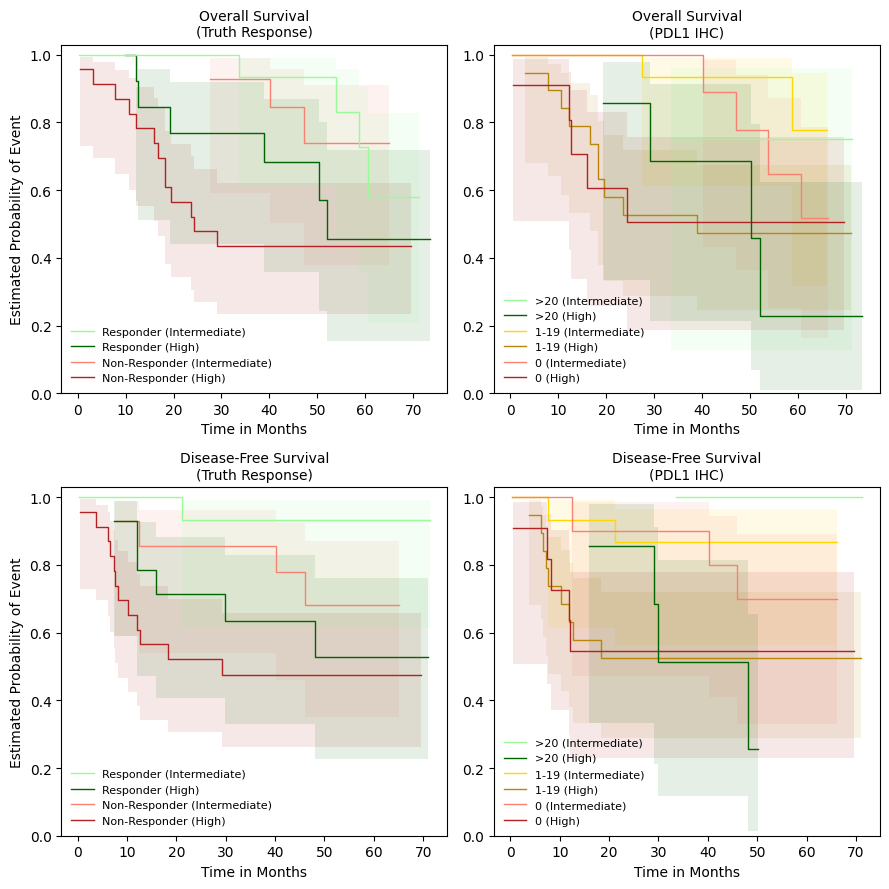

In [5]:
pairwise_truth = hc_data.survival_curve(predicted, name='Truth')

In [6]:
keys_predicted = list(pairwise_prediction.keys())
print(keys_predicted[0])
pairwise_prediction[keys_predicted[0]]

('E_Survival', 'Predicted Treatment Response and Stratification')


,Non-Responder_High,Non-Responder_Intermediate,Responder_High,Responder_Intermediate
Non-Responder_High,1.00,0.02,0.37,0.02
Non-Responder_Intermediate,0.02,1.00,0.19,0.94
Responder_High,0.37,0.19,1.00,0.15
Responder_Intermediate,0.02,0.94,0.15,1.00


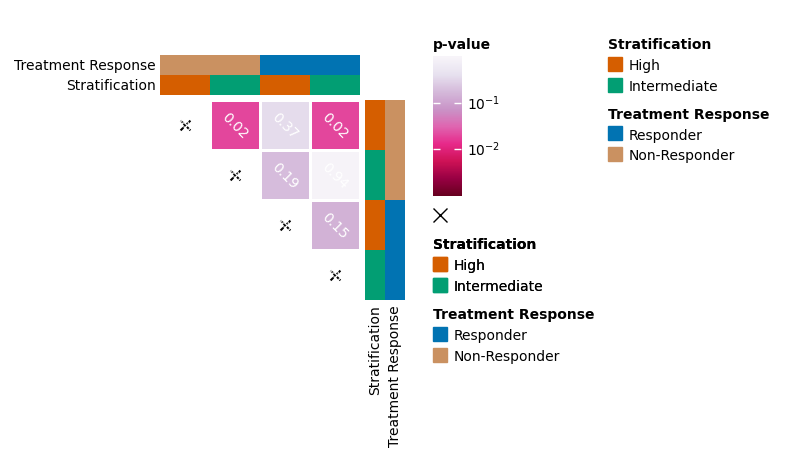

In [7]:
pval_heatmap_response(pairwise_prediction[keys_predicted[0]], name='Prediction_Survival')

In [8]:
print(keys_predicted[1])
pairwise_prediction[keys_predicted[1]]

('E_Survival', 'IHC and Stratification')


,0_High,0_Intermediate,1-19_High,1-19_Intermediate,>20_High,>20_Intermediate
0_High,1.00,0.26,0.95,0.02,0.98,0.34
0_Intermediate,0.26,1.00,0.24,0.35,0.14,0.98
1-19_High,0.95,0.24,1.00,0.01,0.82,0.29
1-19_Intermediate,0.02,0.35,0.01,1.00,0.01,0.53
>20_High,0.98,0.14,0.82,0.01,1.00,0.40
>20_Intermediate,0.34,0.98,0.29,0.53,0.40,1.00


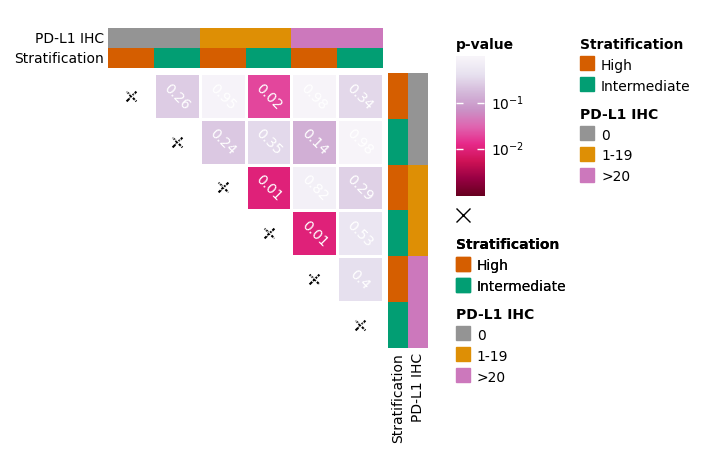

In [9]:
pval_heatmap_ihc(pairwise_prediction[keys_predicted[1]], name='Survival_IHC')

In [10]:
print(keys_predicted[2])
pairwise_prediction[keys_predicted[2]]

('E_Relapse', 'Predicted Treatment Response and Stratification')


,Non-Responder_High,Non-Responder_Intermediate,Responder_High,Responder_Intermediate
Non-Responder_High,1.000,0.11,0.40,0.004
Non-Responder_Intermediate,0.110,1.00,0.39,0.130
Responder_High,0.400,0.39,1.00,0.020
Responder_Intermediate,0.004,0.13,0.02,1.000


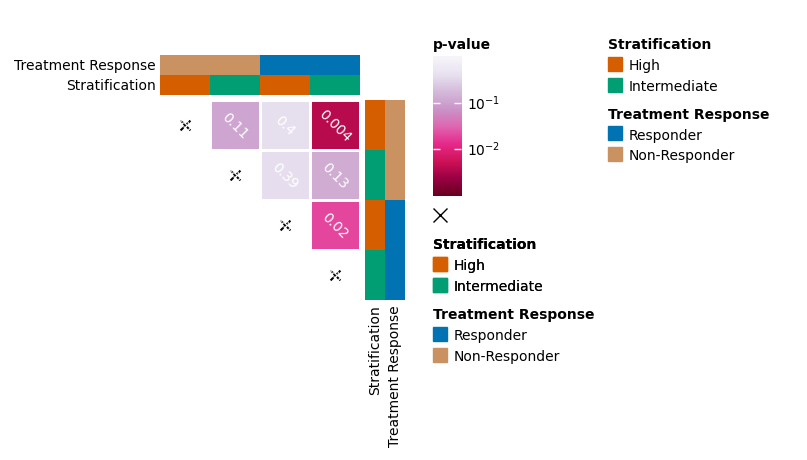

In [11]:
pval_heatmap_response(pairwise_prediction[keys_predicted[2]], name='Prediction_DFS')

In [12]:
print(keys_predicted[3])
pairwise_prediction[keys_predicted[3]]

('E_Relapse', 'IHC and Stratification')


,0_High,0_Intermediate,1-19_High,1-19_Intermediate,>20_High,>20_Intermediate
0_High,1.00,0.27,0.94,0.06,0.99,0.13
0_Intermediate,0.27,1.00,0.23,0.42,0.14,0.36
1-19_High,0.94,0.23,1.00,0.03,0.96,0.12
1-19_Intermediate,0.06,0.42,0.03,1.00,0.03,0.46
>20_High,0.99,0.14,0.96,0.03,1.00,0.09
>20_Intermediate,0.13,0.36,0.12,0.46,0.09,1.00


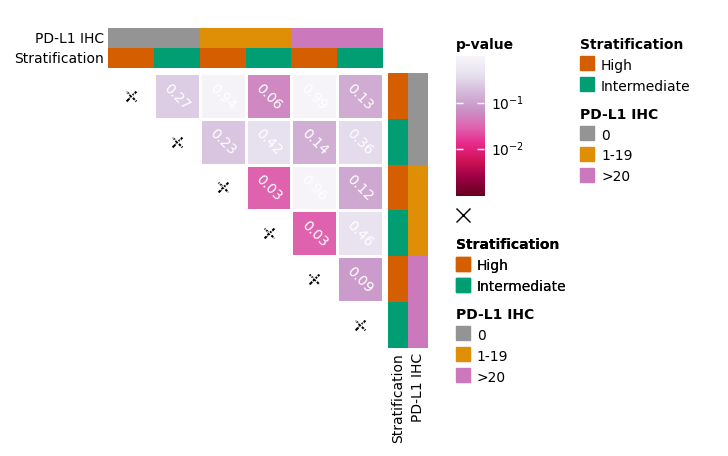

In [13]:
pval_heatmap_ihc(pairwise_prediction[keys_predicted[3]], name='DFS_IHC')

In [14]:
keys_truth = list(pairwise_truth.keys())
print(keys_truth[0])
pairwise_truth[keys_truth[0]]

('E_Survival', 'Predicted Treatment Response and Stratification')


,Non-Responder_High,Non-Responder_Intermediate,Responder_High,Responder_Intermediate
Non-Responder_High,1.00,0.02,0.37,0.02
Non-Responder_Intermediate,0.02,1.00,0.19,0.94
Responder_High,0.37,0.19,1.00,0.15
Responder_Intermediate,0.02,0.94,0.15,1.00


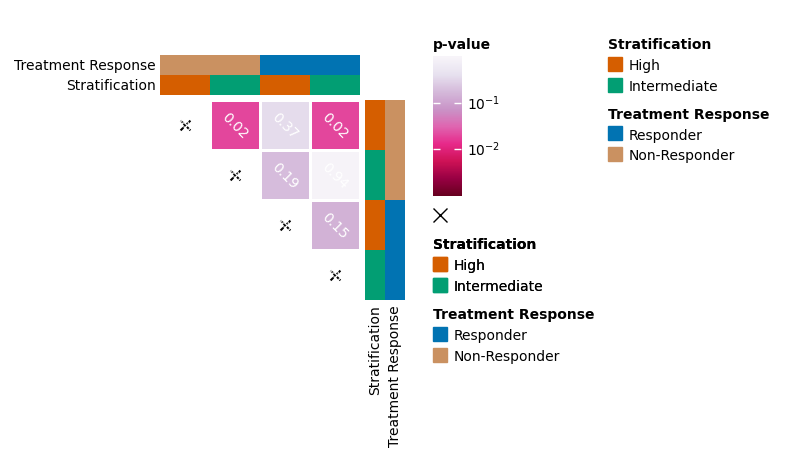

In [15]:
pval_heatmap_response(pairwise_truth[keys_truth[0]], name='Truth_Survival')

In [16]:
print(keys_truth[2])
pairwise_prediction[keys_truth[2]]

('E_Relapse', 'Predicted Treatment Response and Stratification')


,Non-Responder_High,Non-Responder_Intermediate,Responder_High,Responder_Intermediate
Non-Responder_High,1.000,0.11,0.40,0.004
Non-Responder_Intermediate,0.110,1.00,0.39,0.130
Responder_High,0.400,0.39,1.00,0.020
Responder_Intermediate,0.004,0.13,0.02,1.000


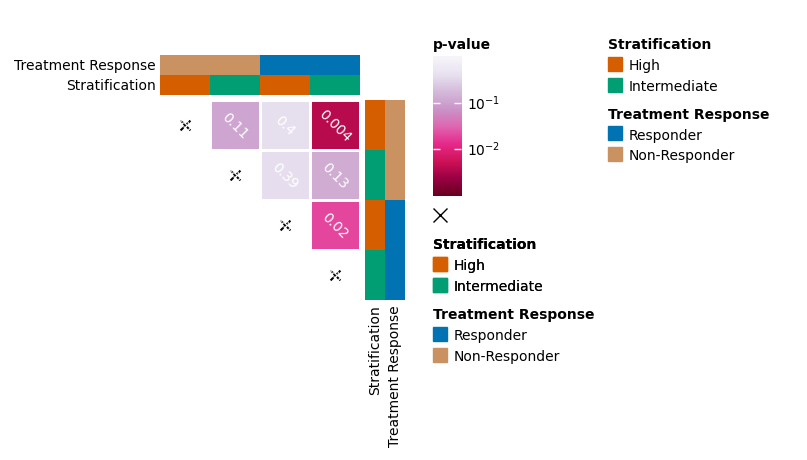

In [17]:
pval_heatmap_response(pairwise_truth[keys_truth[2]], name='Truth_DFS')

In [18]:
def get_tumor_fraction(id):
    file_path = f"../../Data/{id}/{id}.params.txt"
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            second_line = lines[1].strip()
            second_value = float(second_line.split('\t')[1])
            return second_value
    except Exception as e:
        print(f"Error: {e}")
        return None

In [19]:
with open("../../Utils/Lists/valid_ids.txt", 'r') as file:
    valid_ids = [line.strip() for line in file.readlines()]
tumor_fractions = {}

for id in valid_ids:
    tumor_fraction = get_tumor_fraction(id)
    if tumor_fraction is not None:
        tumor_fractions[id] = tumor_fraction

df = pd.DataFrame(list(tumor_fractions.items()), columns=['ID', 'Tumor Fraction'])
df.set_index('ID', inplace=True)
metadata_df = pd.read_csv(METADATA_PATH)
metadata_df = metadata_df[['ID', 'Patient Number', 'Treatment Response']]
df = df.merge(metadata_df, how='left', left_index=True, right_on='ID')
grouped_df = df.groupby('Patient Number')['Tumor Fraction'].mean().reset_index()
median_tf = grouped_df['Tumor Fraction'].median()
grouped_df['Tumor Fraction Level'] = grouped_df['Tumor Fraction'].apply(
    lambda x: 'High TF' if x > median_tf else 'Low TF'
)
grouped_df['Predicted Treatment Response'] = grouped_df['Tumor Fraction'].apply(
    lambda x: 'Non-Responder' if x > median_tf else 'Responder'
)

In [20]:
tumor_fraction = grouped_df.set_index('Patient Number')['Predicted Treatment Response'].to_dict()

In [21]:
tumor_fraction = {switched.get(k, k): v for k, v in tumor_fraction.items()}

# NOTE: This tumor_fraction passes "fake" Responder and Non-Responder labels in leiu of High TF and Low TF. These are then edited in Adobe Illustrator.

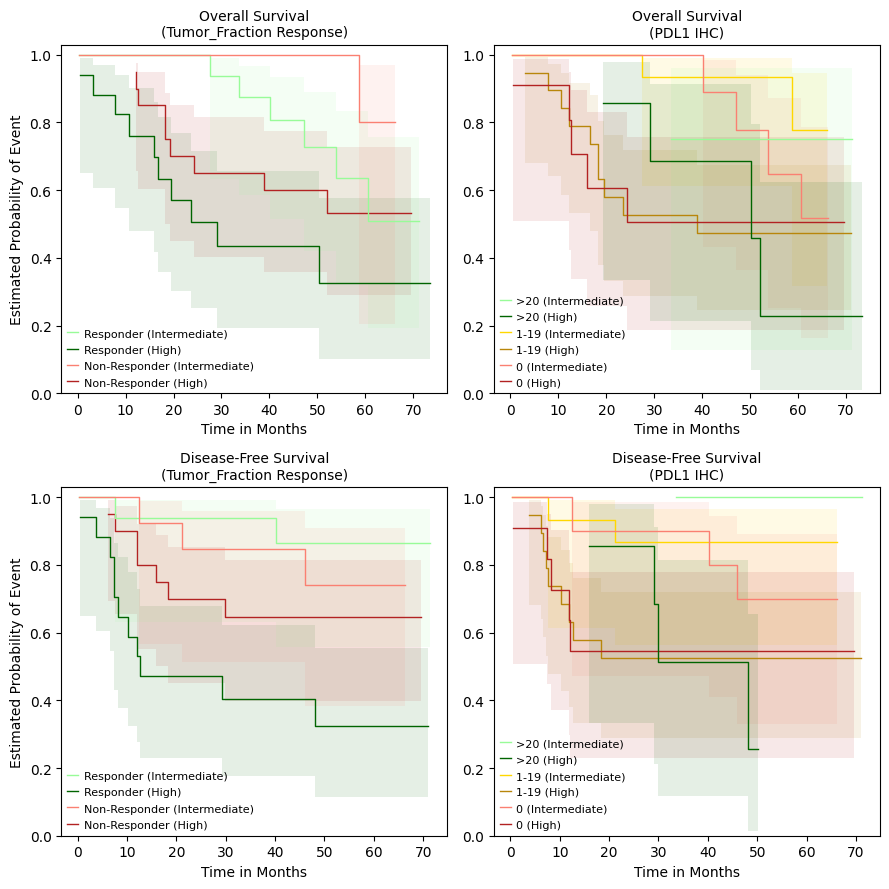

In [22]:
pairwise_tumor = hc_data.survival_curve(tumor_fraction, name='Tumor_Fraction')

In [23]:
keys_tumor = list(pairwise_tumor.keys())
print(keys_tumor[0])
pairwise_tumor[keys_tumor[0]]

('E_Survival', 'Predicted Treatment Response and Stratification')


,Non-Responder_High,Non-Responder_Intermediate,Responder_High,Responder_Intermediate
Non-Responder_High,1.00,0.020,0.190,0.39
Non-Responder_Intermediate,0.02,1.000,0.002,0.12
Responder_High,0.19,0.002,1.000,0.04
Responder_Intermediate,0.39,0.120,0.040,1.00


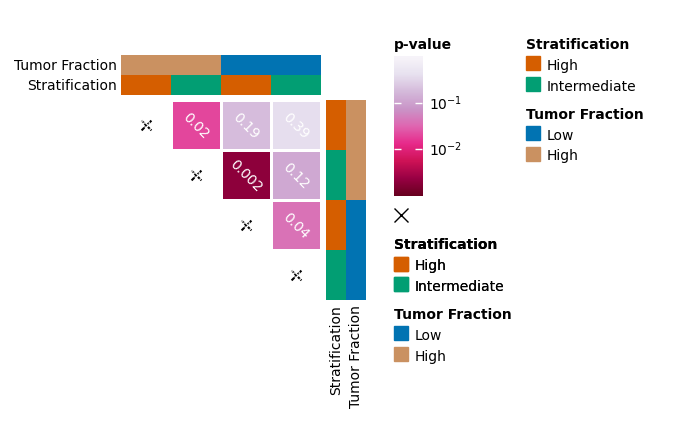

In [24]:
pval_heatmap_tumor(pairwise_tumor[keys_tumor[0]], name='Tumor_Survival')

In [25]:
print(keys_tumor[2])
pairwise_tumor[keys_tumor[2]]

('E_Relapse', 'Predicted Treatment Response and Stratification')


,Non-Responder_High,Non-Responder_Intermediate,Responder_High,Responder_Intermediate
Non-Responder_High,1.00,0.39,0.050,0.120
Non-Responder_Intermediate,0.39,1.00,0.020,0.510
Responder_High,0.05,0.02,1.000,0.002
Responder_Intermediate,0.12,0.51,0.002,1.000


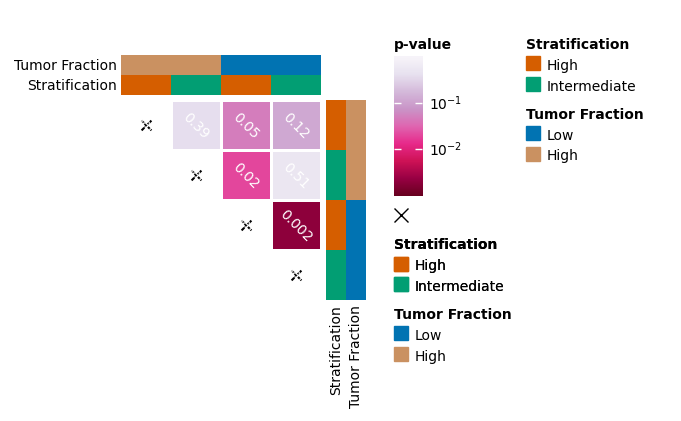

In [26]:
pval_heatmap_tumor(pairwise_tumor[keys_tumor[2]], name='Tumor_DFS')